2 Problem 2 (15 points)
In this problem, you are going to use the same dataset as Problem 1. However, here, you are going to perform autoregressive prediction, just like we did for the Lorenz 63 system. Here, you will write a conditional generative model (either a VAE or a diffusion model) to predict $X(t+1)$ from $X(t)$. Train your model, similar to how we did in class (for Lorenz 63) to train a model that moves forward by one time step. Key points to remember:
- Your generative model would take $X(t+1)$ as input and the label would also be $X(t+1)$
- $X(t)$ is concatenated with the latent space (in case of a VAE) or with the Gaussian noise sample (for diffusion model)
- When you show prediction results for year 1985 , start from the first time step (Jan 1), and autoregressively predict the next few days.
- Plot a few predicted spatial patterns for a few days and the corresponding true patterns for both the channels.
- Plot the MSE error between the predicted and true labels for each channel separately as a function of time.

In [13]:
import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
from netCDF4 import Dataset


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


import matplotlib.pyplot as plt

Bring over the code from Problem 1 to load the data and preprocess it.

dict_keys(['longitude', 'latitude', 'level', 'time', 'z'])


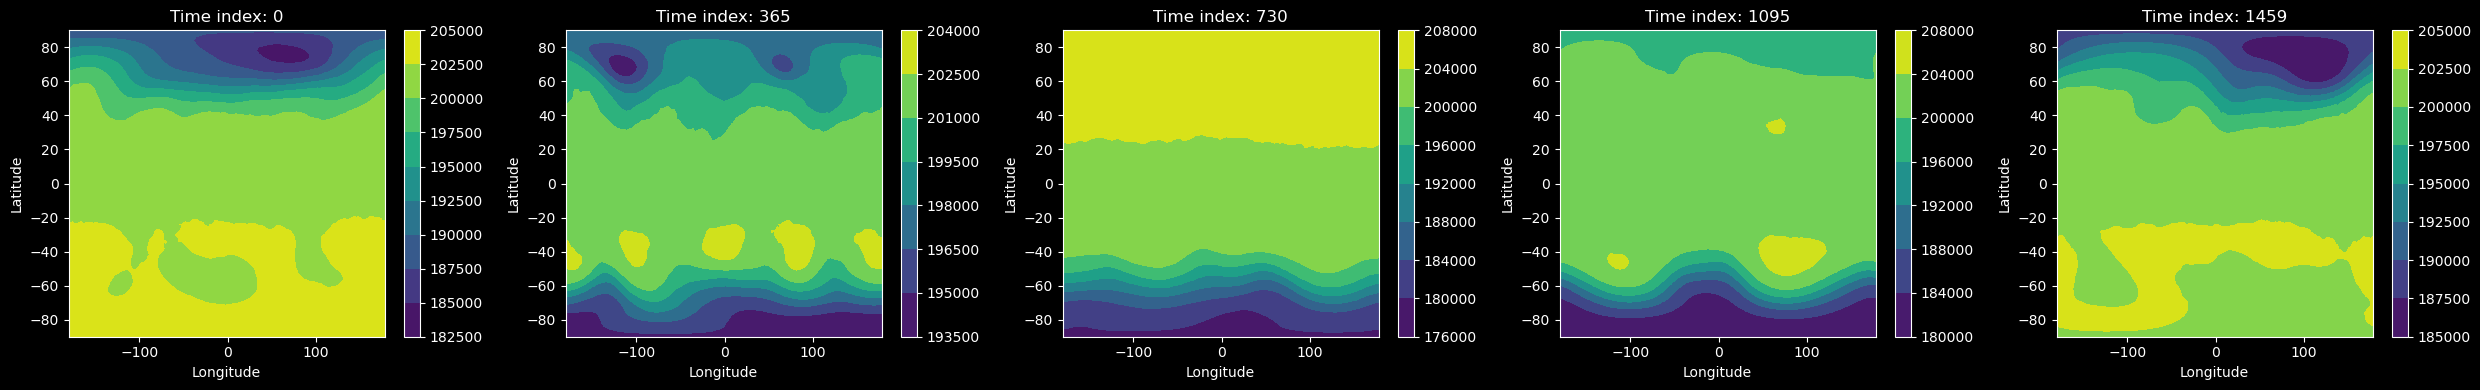

In [14]:
# load datasets for each year
z1979 = Dataset('z1979.nc', 'r')
z1980 = Dataset('z1980.nc', 'r')
z1981 = Dataset('z1981.nc', 'r')
z1983 = Dataset('z1983.nc', 'r')
z1985 = Dataset('z1985.nc', 'r')

# print the keys
print(z1979.variables.keys())
# z1979 = z1979.variables['z'][:]
# (1460, 2, 91, 180)
# time × channel × latitude × longitude.

# Extract the variable 'z' (shape: time × channel × latitude × longitude)
z = z1979.variables['z'][:]  # shape (1460, 2, 91, 180)

# Extract coordinate arrays for latitude and longitude.
# Adjust these variable names if they are different in your file.
lat = z1979.variables['latitude'][:]  # shape (91,)
lon = z1979.variables['longitude'][:]  # shape (180,)

# Define time indices to plot (sampled every 6 hours, so indices correspond to 6-hour intervals)
time_indices = [0, 365, 730, 1095, 1459]

# Create a meshgrid for contour plotting (lon along x-axis, lat along y-axis)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create a figure with subplots (one per selected time step)
fig, axes = plt.subplots(nrows=1, ncols=len(time_indices), figsize=(5 * len(time_indices), 4))

# In case only one time step is selected, ensure axes is a list.
if len(time_indices) == 1:
    axes = [axes]

for ax, t_idx in zip(axes, time_indices):
    # Extract the data for the given time and the first channel.
    # The slice will have shape: (latitude, longitude)
    z_slice = z[t_idx, 0, :, :]  # Using NumPy indexing

    # Create a contour plot with the given coordinate grid and data
    cs = ax.contourf(lon_grid, lat_grid, z_slice, cmap='viridis')

    # Add title and labels for clarity
    ax.set_title(f"Time index: {t_idx}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add a colorbar for the contour plot
    fig.colorbar(cs, ax=ax, orientation='vertical')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [15]:
# Concatenate arrays along the time dimension 
training_data = np.concatenate([
    z1979.variables['z'][:],
    z1980.variables['z'][:],
    z1981.variables['z'][:],
    z1983.variables['z'][:]
], axis=0)

testing_data = z1985.variables['z'][:]
print(training_data.shape)
print(testing_data.shape)

data_mean = np.mean(training_data)
data_std = np.std(training_data)
print(f"Data mean: {data_mean}, Data std: {data_std}")

train = (training_data - data_mean) / data_std
test = (testing_data - data_mean) / data_std

(5844, 2, 91, 180)
(1460, 2, 91, 180)
Data mean: 126784.00788396952, Data std: 72895.64795856815


In [16]:
# we need to pair our time steps because we are predicting the next time step

# Assume train_data_norm is available from your earlier code
# Create training pairs: for each t, condition is X(t) and target is X(t+1)
X_cond_train = train[:-1]     # we index from the start to the second last element
X_target_train = train[1:]    # we index from the second element to the last

# leaving us with a mismatch
# [X(0), X(1), X(2), ..., X(T-1)]
# [X(1), X(2), X(3), ..., X(T)]
print("Training pairs:", X_cond_train.shape, X_target_train.shape)

# Similarly, for testing (using year 1985 data), create pairs
X_cond_test = test[:-1]
X_target_test = test[1:]
print("Testing pairs:", X_cond_test.shape, X_target_test.shape)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_cond_train, dtype=torch.float32), torch.tensor(X_target_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_cond_test, dtype=torch.float32), torch.tensor(X_target_test, dtype=torch.float32))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training pairs: (5843, 2, 91, 180) (5843, 2, 91, 180)
Testing pairs: (1459, 2, 91, 180) (1459, 2, 91, 180)


Lets define our generative model. We will use a VAE for this problem.

In [17]:
# ----- Conditional VAE Architecture -----

class ConditionalConvVAE(nn.Module):
    def __init__(self, in_channels, input_shape=(2, 91, 180), latent_dim=128, cond_dim=128, device="cpu"):
        """
        Args:
            in_channels: number of channels (2)
            input_shape: tuple (channels, lat, lon)
            latent_dim: dimension for the latent space
            cond_dim: dimension for the condition embedding
        """
        super(ConditionalConvVAE, self).__init__()
        self.input_shape = input_shape  # (2, 91, 180)
        self.device = device
        
        # Encoder for X(t+1)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # -> (32, 46, 90)
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # -> (64, 23, 45)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # -> (128, 12, 23)
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),         # -> (256, 6, 12)
            nn.LeakyReLU(0.2)
        ).to(device)
        
        # Compute the shape and size of the encoded representation dynamically
        with torch.no_grad():
            sample_input = torch.zeros(1, *input_shape, device=device)
            sample_output = self.encoder(sample_input)
            self.encoded_shape = sample_output.shape[1:]  # e.g., (256, 6, 12)
            self.encoded_size = sample_output.view(1, -1).size(1)
        
        # Latent space layers
        self.fc_mu = nn.Linear(self.encoded_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoded_size, latent_dim)
        
        # Condition encoder for X(t) (a simpler conv net)
        self.cond_encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),  # -> (16, 46, 90)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),           # -> (32, 23, 45)
            nn.ReLU()
        ).to(device)
        with torch.no_grad():
            sample_cond = torch.zeros(1, in_channels, self.input_shape[1], self.input_shape[2], device=device)
            cond_out = self.cond_encoder(sample_cond)
            self.cond_shape = cond_out.shape[1:]  # e.g., (32, 23, 45)
            self.cond_size = cond_out.view(1, -1).size(1)
        self.fc_cond = nn.Linear(self.cond_size, cond_dim)
        
        # Combine latent vector and condition embedding and project to decoder input size
        self.fc_decode = nn.Linear(latent_dim + cond_dim, self.encoded_size)
        
        # Decoder (mirror of encoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
    def encode(self, x):
        # x is X(t+1)
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar

    def encode_condition(self, cond):
        # cond is X(t)
        h = self.cond_encoder(cond)
        h_flat = h.view(h.size(0), -1)
        cond_vector = self.fc_cond(h_flat)
        return cond_vector

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond_vector):
        # Concatenate latent vector and condition embedding
        z_cond = torch.cat((z, cond_vector), dim=1)
        h_dec = self.fc_decode(z_cond)
        h_dec = h_dec.view(h_dec.size(0), *self.encoded_shape)
        x_recon = self.decoder(h_dec)
        # In case the output size does not match exactly, interpolate
        if x_recon.shape[2:] != self.input_shape[1:]:
            x_recon = F.interpolate(x_recon, size=self.input_shape[1:], mode='bilinear', align_corners=False)
        return x_recon

    def forward(self, cond, target):
        """
        Args:
            cond: condition X(t)
            target: target X(t+1) used in the encoder for learning the latent space
        Returns:
            x_recon: reconstruction of X(t+1)
            mu, logvar: latent parameters
        """
        mu, logvar = self.encode(target)
        z = self.reparameterize(mu, logvar)
        cond_vector = self.encode_condition(cond)
        x_recon = self.decode(z, cond_vector)
        return x_recon, mu, logvar

# Loss function for the conditional VAE (same idea as before)
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [ ]:
def train_conditional_model(model, train_loader, epochs=20, lr=1e-3, device="cpu"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        print(f"\nEpoch {epoch + 1}/{epochs}, learning rate: {lr}")
        
        if epoch > 10 and abs(loss_history[-1] - loss_history[-2]) < 1 and abs(loss_history[-3] - loss_history[-4]) < 1: # if the training stagnates for the last 2 epochs
            if lr > 5e-4:
                lr = 1e-4
                # decrease the learning rate after 10 if the loss epochs to get better convergence
                optimizer = optim.Adam(model.parameters(), lr=lr)
                print(f"loss stagnating, decreasing learning rate to {lr}")
            elif lr > 5e-5:
                lr = 5e-5
                # decrease the learning rate after 10 if the loss epochs to get better convergence
                optimizer = optim.Adam(model.parameters(), lr=lr)
                print(f"loss stagnating, decreasing learning rate to {lr}")
            
        
        for i, (cond, target) in enumerate(train_loader):
            cond = cond.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(cond, target)
            logvar = torch.clamp(logvar, min=-10, max=10)  # clip log variance for stability
            
            loss = cvae_loss(recon, target, mu, logvar)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
            if (i+1) % 100 == 0 or (i+1) == len(train_loader):
                print(f"  Batch {i+1}/{len(train_loader)}: Loss {loss.item():.2f}")
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} average loss: {avg_loss:.2f}")
    return loss_history

# Define device (using cuda/mps/cpu as before)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Training on device:", device)

# Initialize the conditional model
cond_model = ConditionalConvVAE(in_channels=2, input_shape=(2, 91, 180), latent_dim=128, cond_dim=128, device=device)
cond_model = cond_model.to(device)

# Train the model
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_losses = train_conditional_model(cond_model, train_loader, epochs=50, lr=1e-3, device=device)

# Save training loss plot
plt.figure()
plt.yscale('log')
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Conditional VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.grid(True)
loss_plot_filename = os.path.join("loss", f"cond_vae_loss_curve_{timestamp}.png")
plt.savefig(loss_plot_filename)
plt.close()
print(f"Saved training loss curve to {loss_plot_filename}")

# Save the model weights
os.makedirs("weights", exist_ok=True)
weight_filename = os.path.join("weights", f"conditional_convVAE_weights_{timestamp}.pth")
torch.save(cond_model.state_dict(), weight_filename)
print(f"Saved model weights to {weight_filename}")



Training on device: mps

Epoch 1/50, learning rate: 0.001
  Batch 100/366: Loss 29316.49
  Batch 200/366: Loss 2193.68
  Batch 300/366: Loss 24838.54
  Batch 366/366: Loss 293.17
Epoch 1 average loss: 17844.90

Epoch 2/50, learning rate: 0.001
  Batch 100/366: Loss 1157.56
  Batch 200/366: Loss 2176.06
  Batch 300/366: Loss 1011.91
  Batch 366/366: Loss 1513.00
Epoch 2 average loss: 5134.02

Epoch 3/50, learning rate: 0.001
  Batch 100/366: Loss 5207.22
  Batch 200/366: Loss 5932.32
  Batch 300/366: Loss 7544.01
  Batch 366/366: Loss 2460.16
Epoch 3 average loss: 1722195.91

Epoch 4/50, learning rate: 0.001
  Batch 100/366: Loss 1165.99
  Batch 200/366: Loss 577.77
  Batch 300/366: Loss 606.73
  Batch 366/366: Loss 142.19
Epoch 4 average loss: 1668.92

Epoch 5/50, learning rate: 0.001
  Batch 100/366: Loss 609.94
  Batch 200/366: Loss 349.68
  Batch 300/366: Loss 395.51
  Batch 366/366: Loss 93.43
Epoch 5 average loss: 501.54

Epoch 6/50, learning rate: 0.001
  Batch 100/366: Loss 347.

Predicting for steps: [0, 4, 8]
current_input shape: (1459, 2, 91, 180)
Predictions shape (1, 2, 91, 180)


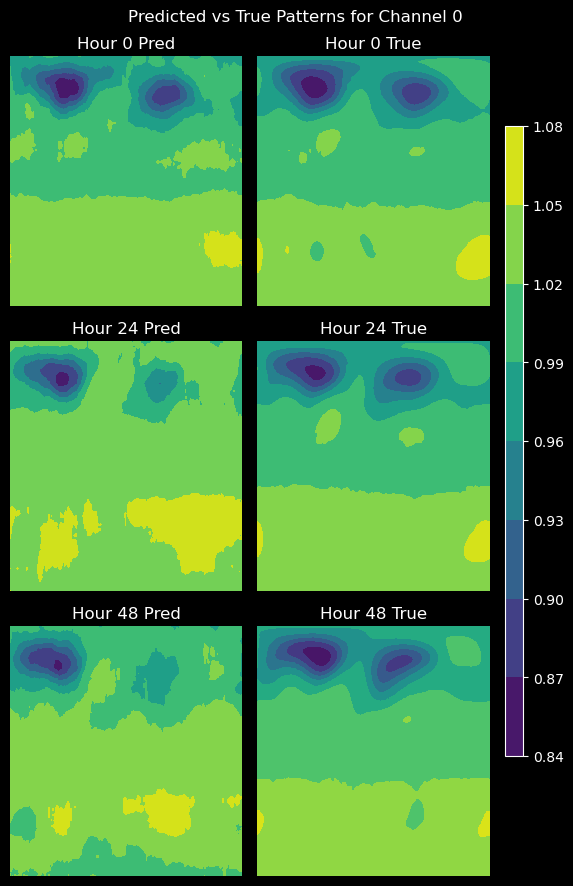

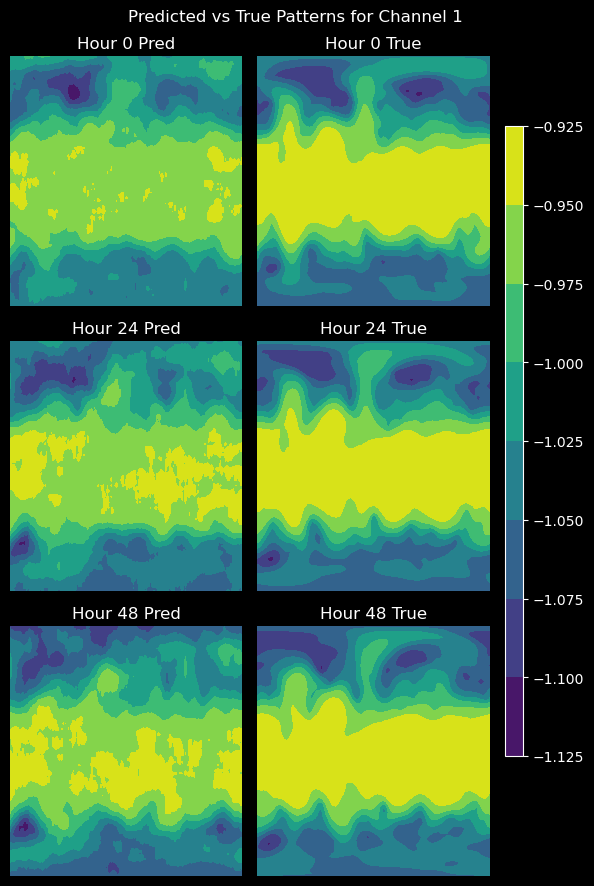

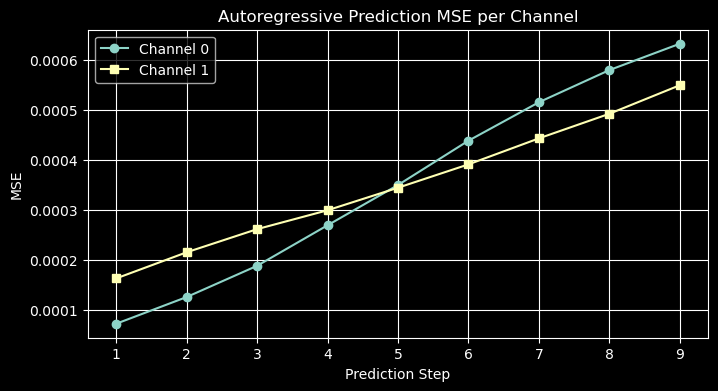

Autoregressive prediction complete.


In [31]:
# ----- Autoregressive Prediction on Test Data (Year 1985) -----

def autoregressive_prediction(model, test_data, n_steps=10, device="cpu"):
    """
    Autoregressively predict X(t+1) from X(t) for n_steps starting from the first time step.
    
    Args:
        model: trained conditional VAE model
        test_data: test_data_norm for year 1985 (numpy array of shape (time, channels, lat, lon))
        n_steps: number of autoregressive prediction steps
    Returns:
        predictions: list of predicted arrays
        mse_per_channel: list of MSE (per channel) at each step compared to true values
    """
    model.eval()
    predictions = []
    mse_per_channel = []
    
    # Start with the first time step
    current_input = torch.tensor(test_data[0:1], dtype=torch.float32, device=device)
    print(f"current_input shape: {test_data.shape}")
    
    # We'll compare predictions with the true sequence
    true_seq = torch.tensor(test_data[1:n_steps+1], dtype=torch.float32, device=device)
    
    with torch.no_grad():
        for step in range(n_steps):
            # For generation, we only have the condition. We sample z from N(0,I)
            batch_size = current_input.size(0)
            # Instead of using the encoder on a target (which we don't have at generation time),
            # we sample a latent vector from the prior.
            z = torch.randn(batch_size, 128, device=device)
            cond_vector = model.encode_condition(current_input)
            # Use the decoder directly
            pred = model.decode(z, cond_vector)
            predictions.append(pred.cpu().numpy())
            
            # Compute channel-wise MSE comparing pred and true_seq[step]
            mse_ch0 = F.mse_loss(pred[:, 0], true_seq[step][0].unsqueeze(0)).item()
            mse_ch1 = F.mse_loss(pred[:, 1], true_seq[step][1].unsqueeze(0)).item()
            mse_per_channel.append((mse_ch0, mse_ch1))
            
            # For the next prediction, set current_input to the predicted state
            current_input = pred
        
    return predictions, mse_per_channel

# Run autoregressive prediction for, say, 10 time steps (a few days)
days = 3
pred_steps = [step*4 for step in range(days)]  # 4 time steps per day
print(f"Predicting for steps: {pred_steps}")
final_step = pred_steps[-1] + 1
predictions, mse_results = autoregressive_prediction(cond_model, X_target_test, n_steps=final_step , device=device)

print(f"Predictions shape {predictions[0].shape}")

for ch in range(2):
    # Plot a few predicted spatial patterns vs true patterns for each channel
    sample_idx = 0  # visualize the first sample in the batch
    # Prepare a grid of plots (rows: channels, columns: time steps)
    fig, axes = plt.subplots(nrows=len(pred_steps), ncols=2, figsize=(3*2, 3*len(pred_steps)))
    for row, step in enumerate(pred_steps):
        # Get the prediction and the corresponding true value (we use X_target_test starting from step 0)
        pred_sample = predictions[step][sample_idx]
        true_sample = np.array(X_target_test[step])  # convert to a numpy array

        ax_pred = axes[row, 0]
        ax_true = axes[row, 1]
        
        # Plot predicted data for channel 0
        im1 = ax_pred.contourf(lon_grid, lat_grid, pred_sample[ch], cmap='viridis')
        ax_pred.set_title(f"Hour {step*6} Pred")
        ax_pred.axis('off')
        
        # Plot true data for channel 0
        im2 = ax_true.contourf(lon_grid, lat_grid, true_sample[ch], cmap='viridis')
        ax_true.set_title(f"Hour {step*6} True")
        ax_true.axis('off')
            
    # Add a title and display the plot
    fig.suptitle(f"Predicted vs True Patterns for Channel {ch}")
    # # Add a shared colorbar to the entire figure
    # fig.colorbar(im1, ax=axes.ravel().tolist(), orientation='vertical')

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    plt.savefig(f"plots/autoregressive_predictions_channel{ch}_{timestamp}.png")
    plt.show()
    plt.close()

# Plot the MSE error per channel as a function of time
mse_ch0 = [mse[0] for mse in mse_results]
mse_ch1 = [mse[1] for mse in mse_results]
plt.figure(figsize=(8, 4))
plt.plot(range(1, final_step+1), mse_ch0, marker='o', label='Channel 0')
plt.plot(range(1, final_step+1), mse_ch1, marker='s', label='Channel 1')
plt.xlabel("Prediction Step")
plt.ylabel("MSE")
plt.title("Autoregressive Prediction MSE per Channel")
plt.legend()
plt.grid(True)
plt.savefig(f"plots/autoregressive_mse_{timestamp}.png")
plt.show()
plt.close()

print("Autoregressive prediction complete.")